In [193]:
from functools import partial

In [2]:
import pandas as pd

In [444]:
import swifter

In [313]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [3]:
from rapidfuzz import process, fuzz

In [105]:
fact_corpus = pd.read_parquet('factiva_download_2015_2023/new_articles.parquet')
ged_corpus = pd.read_parquet('ucdp_texts/ucdp_ged_factiva.parquet')


In [106]:
fact_corpus = fact_corpus.reset_index(drop=True)

In [111]:
fact_corpus = fact_corpus.set_index('an')

In [9]:
fact_corpus['source_code'].unique()

array(['AJAZEN', 'AFNWS', 'LBA', 'APRS', 'XNEWS', 'AFPR', 'BBCSUP',
       'BBCSAP', 'BBCCAU', 'BBCEUP', 'BBCCA', 'BBCMNF', 'BBCAP', 'BBCMEP',
       'BBCUKB', 'BBCAPP', 'BBCMAP', 'BBCMM'], dtype=object)

In [19]:
fact_corpus[fact_corpus.source_code=='AFPR']

,copyright,subject_codes,modification_datetime,body,company_codes_occur_ticker_exchange,company_codes_occur,company_codes_about,company_codes_lineage,company_codes_ticker_exchange,snippet,...,company_codes_relevance,source_code,an,word_count,company_codes,industry_codes,title,publication_datetime,publisher_name,action
5581,"Copyright Agence France-Presse, 2015 All repro...",",gpol,gcat,gpir,",2015-03-13 15:21:18,"Castro, who stepped down after falling ill in ...",,,,,,Cuba's retired leader Fidel Castro has been se...,...,",flntun,",AFPR,AFPR000020150203eb23008vm,624,",flntun,",,Fidel Castro seen in photos for first time in ...,2015-02-03 21:39:16,Agence France-Presse,rep
5582,"Copyright Agence France-Presse, 2016 All repro...",",gvio,gcat,gcns,grisk,",2016-09-17 00:01:10,The ceasefire has been marred by a lack of hum...,,",utdnat,unscou,",",utdnat,unscou,",,,Air strikes and clashes tested a fragile cease...,...,",utdnat,unscou,syobhu,",AFPR,AFPR000020160917ec9h00001,874,",syobhu,unscou,unscou,utdnat,utdnat,unscou,utd...",,"Fragile Syria truce tested by violence, US-Rus...",2016-09-17 00:00:25,Agence France-Presse,add
5583,"Copyright Agence France-Presse, 2016 All repro...",",gpol,gterr,gvdef,gcat,gcns,gcrim,gpir,gvbod,g...",2016-06-09 07:51:32,France until now has only acknowledged the pre...,,",chbdo,",",aqdirq,",,,France has deployed special forces in northern...,...,",chbdo,",AFPR,AFPR000020160609ec69006bt,423,",chbdo,chbdo,aqdirq,",,France says special forces in Syria advising r...,2016-06-09 07:51:26,Agence France-Presse,rep
5584,"Copyright Agence France-Presse, 2016 All repro...",",gpol,gterr,gcat,gcns,gcrim,gpir,ncat,nfact,nf...",2016-08-29 16:41:57,Around 30 towns have banned the burkini from t...,,",lcfcme,",",lcfcme,",,,France's government sought Monday to open a ne...,...,",lcfcme,",AFPR,AFPR000020160829ec8t00c9p,518,",lcfcme,lcfcme,lcfcme,",,France seeks new chapter in Muslim relations,2016-08-29 16:41:45,Agence France-Presse,add
5585,"Copyright Agence France-Presse, 2016 All repro...",",garig,ggrey,gcat,gcom,gspo,ncat,nfact,nfce,nrgn,",2016-08-24 04:46:27,Although opposed by the dog racing industry an...,,,,,,Greyhound racing has been outlawed in Australi...,...,",aubc,",AFPR,AFPR000020160824ec8o0040h,415,",aubc,",,Uproar as Australian state bans greyhound racing,2016-08-24 04:46:19,Agence France-Presse,add
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15812,"Copyright Agence France-Presse, 2015 All repro...",",gearth,gdev,gcat,gdip,gdis,gntdis,gpir,grisk,",2015-06-18 07:13:54,"Almost every house in Sirdibas, in the worst-h...",,,,,,"For the villagers of Sirdibas in Nepal, one of...",...,",utdnat,",AFPR,AFPR000020150618eb6i003mu,712,",utdnat,",,Nepal quake leaves remote villages cut off as ...,2015-06-18 07:12:36,Agence France-Presse,add
15813,"Copyright Agence France-Presse, 2015 All repro...",",gdip,gvio,gcat,gcns,gpir,grisk,",2015-05-15 12:08:25,"Crumbling houses, flats on the verge of collap...",,,",utdnat,",,,Forty years since the jet-set graced Varosha's...,...,",utdnat,",AFPR,AFPR000020150515eb5f006yb,745,",utdnat,utdnat,",,Fate of Cyprus ghost town rests with peace talks,2015-05-15 12:06:28,Agence France-Presse,add
15814,"Copyright Agence France-Presse, 2015 All repro...",",gcrim,gmurd,gpol,nobt,gcat,gpir,ncat,nfact,nf...",2015-06-05 17:17:07,"Aziz was found guilty of ""deliberate murder an...",,,,,,Iraq's jailed former foreign minister Tareq Az...,...,",utdnat,",AFPR,AFPR000020150605eb65006vc,756,",utdnat,",,"Tareq Aziz, voice of Saddam's brutal rule, die...",2015-06-05 17:14:45,Agence France-Presse,rep
15815,"Copyright Agence France-Presse, 2015 All repro...",",gdef,gterr,gcat,gcns,gcrim,grisk,ncat,nfact,n...",2015-05-20 11:07:41,"Before escaping, he shot and wounded the guard...",,",utdnat,",,,,A militant opened fire on a United Nations res...,...,",utdnat,",AFPR,AFPR000020150520eb5k0070v,374,",utdnat,utdnat,",,Guard wounded in attack on UN personnel in Mal...,2

In [10]:
ged_corpus.source_name.unique()

array(['Agence France Presse', 'All Africa', 'Reuters News',
       'Associated Press Newswires', 'BBC Monitoring Americas',
       'BBC Monitoring European', 'Xinhua News Agency',
       'BBC Monitoring Middle East', 'BBC Monitoring Newsfile',
       'AllAfrica', 'BBC Monitoring Asia Pacific', 'Reuters',
       'BBC Monitoring Caucasus', 'BBC Monitoring Africa',
       'BBC Monitoring South Asia', 'BBC Monitoring Central Asia',
       'Al Jazeera', 'Reuters News '], dtype=object)

In [112]:
ged_corpus['base_name'] = None
ged_corpus.loc[ged_corpus.source_name.str.contains('BBC'),'base_name'] = 'BBC'
ged_corpus.loc[ged_corpus.source_name.str.contains('Jazeera'),'base_name'] = 'AJAZEN'
ged_corpus.loc[ged_corpus.source_name.str.contains('Xinhua'),'base_name'] = 'XNEWS'
ged_corpus.loc[ged_corpus.source_name.str.contains('Africa'),'base_name'] = 'AFNWS'
ged_corpus.loc[ged_corpus.source_name.str.contains('Reuters'),'base_name'] = 'LBA'
ged_corpus.loc[ged_corpus.source_name.str.contains('France'),'base_name'] = 'AFPR'
ged_corpus.loc[ged_corpus.source_name.str.contains('Associate'),'base_name'] = 'APRS'

In [113]:
fact_corpus['base_name'] = fact_corpus.source_code
fact_corpus.loc[fact_corpus.base_name.str.contains('BBC'),'base_name'] = 'BBC'

In [114]:
fact_corpus['publication_datetime'] = pd.to_datetime(fact_corpus.publication_datetime)
ged_corpus['source_date'] = pd.to_datetime(ged_corpus.source_date)

In [70]:
fact_corpus.publication_datetime.between(test_case.source_date-pd.timedelta())

<bound method Series.between of 0       2016-07-29 00:00:00
1       2016-10-01 00:00:00
2       2016-10-21 00:00:00
3       2016-10-11 00:00:00
4       2016-09-09 00:00:00
                ...        
15839   2022-10-23 07:06:01
15840   2023-03-28 17:50:42
15841   2015-05-13 15:00:43
15842   2015-05-08 13:16:18
15843   2015-07-23 12:45:05
Name: publication_datetime, Length: 2126054, dtype: datetime64[ns]>

In [45]:
test_article = ged_corpus.loc[83758]

In [115]:
test_case = ged_corpus.loc[1]

In [68]:
fact_corpus[fact_corpus.title.str.contains("Nigerian Troops Kill Dozens of")].iloc[0].title

'Nigerian Troops Kill Dozens of Insurgents, Recover Arms, Hostages [press release]'

In [69]:
fact_corpus

,copyright,subject_codes,modification_datetime,body,company_codes_occur_ticker_exchange,company_codes_occur,company_codes_about,company_codes_lineage,company_codes_ticker_exchange,snippet,...,source_code,an,word_count,company_codes,industry_codes,title,publication_datetime,publisher_name,action,base_name
0,Copyright 2016 Al Jazeera English.,",gkdnap,gimm,gtortu,gcat,gcom,gcrim,ghum,gpir,",2016-07-29 14:03:20,"Poverty, persecution and conflict are among th...",,,",doctwb,",,,"Rescued at sea, refugees are subject to kidnap...",...,AJAZEN,AJAZEN0020160729ec7t000p1,198,",doctwb,doctwb,",,Rescued refugees detail abuse in Libya,2016-07-29 00:00:00,Al Jazeera International,add,AJAZEN
1,Copyright 2016 Al Jazeera English.,",gbolly,gcat,gent,gmovie,",2016-10-02 05:01:18,Indian films made in Bollywood are being boyco...,,,,,,Bollywood and Pakistani artists caught in the ...,...,AJAZEN,AJAZEN0020161002eca100009,153,",ajzral,utdnat,",,Why is art being dragged into Kashmir conflict?,2016-10-01 00:00:00,Al Jazeera International,add,AJAZEN
2,Copyright 2016 Al Jazeera English.,",ghum,gcrim,gvio,gwar,gcat,gcns,gcom,grisk,",2016-10-21 15:06:12,Zeid Ra'ad al Hussein's comments on Friday cam...,,",utdnat,iccou,",",utdnat,unhrc,iccou,",,,UN human rights chief Zeid Ra'ad al Hussein sa...,...,AJAZEN,AJAZEN0020161021ecal000ru,796,",iccou,euruno,iccou,iccou,rumde,syobhu,utdnat,...",,UN rights chief denounces Aleppo raids as 'war...,2016-10-21 00:00:00,Al Jazeera International,add,AJAZEN
3,Copyright 2016 Al Jazeera English.,",gterr,gcat,gcns,gcrim,ncat,nfact,nfcpex,",2016-10-11 14:05:04,Myth 1: ISIL emerged out of a vacuum\n\nDuring...,,,",aqdirq,",,,"Trump offered no new ISIL strategy, but recycl...",...,AJAZEN,AJAZEN0020161011ecab000uo,992,",absyyg,ajzral,aqdirq,",,Donald Trump and the mythology of ISIL's rise,2016-10-11 00:00:00,Al Jazeera International,add,AJAZEN
4,Copyright 2016 Al Jazeera English.,",gexplo,gcat,gdis,gmmdis,",2016-09-09 08:06:17,An earthquake with a magnitude of 5.3 was dete...,,",usglsy,unscou,jpmtag,",",usglsy,unscou,",,,"Pyongyang says it carried out ""nuclear warhead...",...,AJAZEN,AJAZEN0020160909ec99000dx,828,",jpmtag,sipriw,unscou,unscou,usglsy,usglsy,uns...",,North Korea hails 'successful' nuclear test,2016-09-09 00:00:00,Al Jazeera International,add,AJAZEN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15839,(c) 2022 The British Broadcasting Corporation....,",ghack,nnam,gcat,gcrim,ncat,nfact,nfce,nfcpex,...",2022-10-23 07:07:08,The victims - most of them women and children ...,,",utdnat,",,,,By BBC Monitoring\n\nAt least 20 people were h...,...,BBCMNF,BBCMNF0020221023eian000b5,195,",utdnat,utdnat,",,Twenty people hacked to death in DR Congo rebe...,2022-10-23 07:06:01,The British Broadcasting Corporation,add,BBC
15840,(c) 2023 The British Broadcasting Corporation....,",ntra,gpol,gcat,gpir,ncat,nfact,nfce,nfcpex,niwe,",2023-03-28 17:51:48,The same rebels occupied the village of Bweru ...,,",utdnat,",,,,Text of report by DR Congo's UN-sponsored Radi...,...,BBCAP,BBCAP00020230328ej3s000p1,319,",utdnat,utdnat,",,M23 rebels capture several localities in DR Co...,2023-03-28 17:50:42,The British Broadcasting Corporation,add,BBC
15841,(c) 2015 The British Broadcasting Corporation....,",gdip,gvio,gcat,gcns,gpir,grisk,",2015-05-13 15:07:30,"""Unfortunately, what is presently going on in ...",,,,,,Excerpt of report in English by Iranian conser...,...,BBCMEP,BBCMEP0020150513eb5d0030d,461,",utdnat,",,Iran's judiciary chief condemns Saudi air stri...,2015-05-13 15:00:43,The British Broadcasting Corporation,add,BBC
15842,(c) 2015 The British Broadcasting Corporation....,",gcivds,gcat,gcns,grisk,",2015-05-08 13:21:55,Demonstrators in Mutakura neighbourhood [of th...,,,,,,Text of report by privately-owned Burundian Ra...,...,BBCMNF,BBCMNF0020150508eb58001up,546,",utdnat,",,Burundian protesters seize youths carrying gre...,2015-05-08 13:16:18,The British Broadcasting Corporation,add,BBC


In [177]:
def search_it(row, 
              window_days = 2, 
              min_acceptance = 90):
    """
    Search for articles using fuzzy string matching search search.
    window_days is how many days can differ from UCDP publication to actual publication
    min_acceptance (0,100) is the WRatio acceptance score (0-100, w/ 100=perfect concordance)
    :returns a tuple with article name, score, Factiva AN
    """
    try:
        if row.curid % 100 == 0 : print(row.curid,end=" ")
    except:
        pass
    
    haystack = fact_corpus[fact_corpus.publication_datetime.between(row.source_date-pd.Timedelta('2 days'), 
                                                                    row.source_date+pd.Timedelta('2 days'))]
    haystack = haystack[haystack.base_name == row.base_name]
    empty = ('',0,None)
    
    try:
        found = process.extract(row.headline, haystack.title, scorer=fuzz.WRatio, limit=1)[0]
        if found[1]<min_acceptance:
            found = empty
    except IndexError:
        found = empty
    return found

In [174]:
search_it(test_case)

('Nigerian Troops Kill Dozens of Insurgents, Recover Arms, Hostages [press release]',
 100.0,
 'AFNWS00020160125ec1p0013q')

In [171]:
ged_corpus['curid'] =  ged_corpus.index
ged_corpus

,article_id,headline,source_date,article_text,source_id,GedEvent_id,source_name,id,what,date_end,...,RootNode_id,geoid,latitude,Longitude,pg_id,name,root_id,country_name2,base_name,curid
0,64831,IS attack on Kurdish forces in Syria kills 16:...,2015-05-06 10:09:00,At least 16 members of Syrian Kurdish security...,7,214713,Agence France Presse,214713,At least 16 members of Syrian Kurdish security...,2015-05-06 00:00:00.000,...,4754,82164,36.502368,40.747716,182602,Al Hasakah town,4754,Syria,AFPR,0
1,69339,"Nigerian Troops Kill Dozens of Insurgents, Rec...",2016-01-25 15:44:00,"Jan 25, 2016 (Premium Times/All Africa Global ...",11,218838,All Africa,218838,"""In another development, one of our units loca...",2016-01-22 00:00:00.000,...,4722,36341,12.365320,13.829300,147268,Old Marte town,4722,Nigeria,AFNWS,1
2,72636,UPDATE 3-Iraq forces keep up shelling of Fallu...,2016-05-24 15:21:00,* Battle has begun to retake city close to Bag...,4,224930,Reuters News,224930,Air strikes and mortar salvoes overnight targe...,2016-05-23 00:00:00.000,...,74203,74304,33.355813,43.786124,177568,Al Fallūjah town,74203,Iraq,LBA,2
3,64833,Assad says army to reinforce besieged troops i...,2015-05-06 15:01:00,BEIRUT (Reuters) - Syrian President Bashar al-...,4,214714,Reuters News,214714,Fighting continued on Wednesday between govern...,2015-05-06 00:00:00.000,...,4754,122264,35.700000,36.100000,181153,Northern Latakia governorate,4754,Syria,LBA,3
4,64835,IS launches offensive in east Syria city: moni...,2015-05-06 18:23:00,The Islamic State jihadist group launched an o...,7,214716,Agence France Presse,214716,\nThe Islamic State jihadist group launched an...,2015-05-08 00:00:00.000,...,4754,82167,35.335876,40.140844,180441,Deir ez Zor town,4754,Syria,AFPR,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83756,434300,End of truce: Colombia kills two cartel member...,2023-03-22 00:29:00,The Colombian army said Tuesday it had killed ...,7,469607,Agence France Presse,469607,The Colombian army said Tuesday it had killed ...,2023-03-22 00:00:00.000,...,57783,74018,9.000000,-74.333333,142772,Bolívar department,57783,Colombia,AFPR,83756
83757,434399,"Xinhua world news summary at 1530 GMT, April 3",2023-04-03 17:35:00,MANILA -- Philippine security forces clashed w...,10,469673,Xinhua News Agency,469673,Army Lieutenant Colonel Hector Estolas said tr...,2023-03-31 00:00:00.000,...,179042,180556,14.583330,121.166670,151083,Rizal province,179042,Philippines,XNEWS,83757
83758,434393,4 killed as Philippine security forces clash w...,2023-04-03 13:57:00,"MANILA, April 3 (Xinhua) -- Philippine securit...",10,469673,Xinhua News Agency,469673,Army Lieutenant Colonel Hector Estolas said tr...,2023-03-31 00:00:00.000,...,179042,180556,14.583330,121.166670,151083,Rizal province,179042,Philippines,XNEWS,83758
83759,434397,4 killed as Philippine security forces clash w...,2023-04-03 13:57:00,"MANILA, April 3 (Xinhua) -- Philippine securit...",10,469677,Xinhua News Agency,469677,Police Brigadier General Allan Nobleza said po...,2023-04-02 00:00:00.000,...,179042,180328,7.900000,124.350000,141009,Lanao del Sur province,179042,Philippines,XNEWS,83759


In [194]:
search_wide = partial(search_it, 
                      window_days = 10, 
                      min_acceptance = 50)

In [195]:
match_wide = ged_corpus.apply(search_wide, axis=1)

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700 6800 6900 7000 7100 7200 7300 7400 7500 7600 7700 7800 7900 8000 8100 8200 8300 8400 8500 8600 8700 8800 8900 9000 9100 9200 9300 9400 9500 9600 9700 9800 9900 10000 10100 10200 10300 10400 10500 10600 10700 10800 10900 11000 11100 11200 11300 11400 11500 11600 11700 11800 11900 12000 12100 12200 12300 12400 12500 12600 12700 12800 12900 13000 13100 13200 13300 13400 13500 13600 13700 13800 13900 14000 14100 14200 14300 14400 14500 14600 14700 14800 14900 15000 15100 15200 15300 15400 15500 15600 15700 15800 15900 16000 16100 16200 16300 16400 16500 16600 16700 16800 16900 17000 17100 17200 17300 17400 17500 17600 17700 17800 17900 18000 18100 18200 18300 18400 18

In [178]:
match_res = ged_corpus.apply(search_it, axis=1)s

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700 6800 6900 7000 7100 7200 7300 7400 7500 7600 7700 7800 7900 8000 8100 8200 8300 8400 8500 8600 8700 8800 8900 9000 9100 9200 9300 9400 9500 9600 9700 9800 9900 10000 10100 10200 10300 10400 10500 10600 10700 10800 10900 11000 11100 11200 11300 11400 11500 11600 11700 11800 11900 12000 12100 12200 12300 12400 12500 12600 12700 12800 12900 13000 13100 13200 13300 13400 13500 13600 13700 13800 13900 14000 14100 14200 14300 14400 14500 14600 14700 14800 14900 15000 15100 15200 15300 15400 15500 15600 15700 15800 15900 16000 16100 16200 16300 16400 16500 16600 16700 16800 16900 17000 17100 17200 17300 17400 17500 17600 17700 17800 17900 18000 18100 18200 18300 18400 18

In [182]:
match_res

0        (IS attack on Kurdish forces in Syria kills 16...
1        (Nigerian Troops Kill Dozens of Insurgents, Re...
2        (UPDATE 3-Iraq forces keep up shelling of Fall...
3        (Assad says army to reinforce besieged troops ...
4                                              (, 0, None)
                               ...                        
83756    (End of truce: Colombia kills two cartel membe...
83757                                          (, 0, None)
83758                                          (, 0, None)
83759                                          (, 0, None)
83760                                          (, 0, None)
Length: 83761, dtype: object

In [196]:
ged_corpus['title_match'] = [i[0] for i in match_res]
ged_corpus['match_score'] = [i[1] for i in match_res]
ged_corpus['an'] = [i[2] for i in match_res]

ged_corpus['title_match_wide'] = [i[0] for i in match_wide]
ged_corpus['match_score_wide'] = [i[1] for i in match_wide]
ged_corpus['an_wide'] = [i[2] for i in match_wide]

In [197]:
ged_corpus_matched = ged_corpus[ged_corpus.year>=2015]

In [202]:
print(f"Not Matched : {ged_corpus_matched[ged_corpus_matched.an.isna()].shape[0]}")
print(f"Not Matched Wide: {ged_corpus_matched[ged_corpus_matched.an_wide.isna()].shape[0]}")
print(f"Total: {ged_corpus_matched.shape[0]}")

Not Matched : 6717
Not Matched Wide: 175
Total: 61517


In [307]:
weak_match = ged_corpus_matched[(ged_corpus_matched.match_score_wide<85) 
                                & (ged_corpus_matched.match_score_wide>0)]
weak_match[['headline','title_match_wide','match_score','match_score_wide']]

,headline,title_match_wide,match_score,match_score_wide
7509,"Five dead, two injured in Canada school shooting",Five students wounded in Turkey school attack ...,0.0,53.773585
8687,Armenia reports casualties amid border tension...,No casualties reported in E. Ukraine amid ceas...,0.0,59.375000
9004,California police answering gunman report shoo...,"Palestinian stabs Israeli policeman, shot dead",0.0,52.293578
9094,Nord-Kivu - Les milices APCLS et Nyatura signe...,Forces End Deadly Restaurant Siege,0.0,50.294118
11646,Canada PM condemns mosque shooting as 'terrori...,Hollande condemns 'odious' Quebec attack,0.0,56.842105
...,...,...,...,...
79093,"Après les attentats au Bénin, l'armée français...",France says air strikes kill 40 in Burkina lin...,0.0,56.449275
79539,AQAP mourns senior figure 'killed in US air st...,Yemen rebels say two women killed in coalition...,0.0,60.603448
81827,"Man kills Toronto cop, 1 other before being ki...","Palestinian man left beaten, bloodied by Isra...",0.0,52.123894
81828,"Man kills Toronto cop, 1 other before being ki...","Palestinian man left beaten, bloodied by Isra...",0.0,52.123894


<Axes: ylabel='Density'>

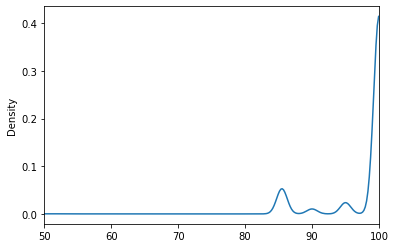

In [306]:
ged_corpus_matched.match_score_wide.plot.kde(xlim=(50,100))

In [329]:
positives_from_ged = ged_corpus[ged_corpus.match_score_wide>87.5]
positives_from_ged

,article_id,headline,source_date,article_text,source_id,GedEvent_id,source_name,id,what,date_end,...,root_id,country_name2,base_name,curid,title_match,match_score,an,title_match_wide,match_score_wide,an_wide
0,64831,IS attack on Kurdish forces in Syria kills 16:...,2015-05-06 10:09:00,At least 16 members of Syrian Kurdish security...,7,214713,Agence France Presse,214713,At least 16 members of Syrian Kurdish security...,2015-05-06 00:00:00.000,...,4754,Syria,AFPR,0,IS attack on Kurdish forces in Syria kills 16:...,100.0,AFPR000020150506eb56007bx,IS attack on Kurdish forces in Syria kills 16:...,100.0,AFPR000020150506eb56007bx
1,69339,"Nigerian Troops Kill Dozens of Insurgents, Rec...",2016-01-25 15:44:00,"Jan 25, 2016 (Premium Times/All Africa Global ...",11,218838,All Africa,218838,"""In another development, one of our units loca...",2016-01-22 00:00:00.000,...,4722,Nigeria,AFNWS,1,"Nigerian Troops Kill Dozens of Insurgents, Rec...",100.0,AFNWS00020160125ec1p0013q,"Nigerian Troops Kill Dozens of Insurgents, Rec...",100.0,AFNWS00020160125ec1p0013q
2,72636,UPDATE 3-Iraq forces keep up shelling of Fallu...,2016-05-24 15:21:00,* Battle has begun to retake city close to Bag...,4,224930,Reuters News,224930,Air strikes and mortar salvoes overnight targe...,2016-05-23 00:00:00.000,...,74203,Iraq,LBA,2,UPDATE 3-Iraq forces keep up shelling of Fallu...,100.0,LBA0000020160524ec5o00vk8,UPDATE 3-Iraq forces keep up shelling of Fallu...,100.0,LBA0000020160524ec5o00vk8
3,64833,Assad says army to reinforce besieged troops i...,2015-05-06 15:01:00,BEIRUT (Reuters) - Syrian President Bashar al-...,4,214714,Reuters News,214714,Fighting continued on Wednesday between govern...,2015-05-06 00:00:00.000,...,4754,Syria,LBA,3,Assad says army to reinforce besieged troops i...,100.0,LBA0000020150506eb5600gz5,Assad says army to reinforce besieged troops i...,100.0,LBA0000020150506eb5600gz5
5,74032,UN warns of dangers as Iraqis displaced by IS ...,2016-07-28 19:16:00,BAGHDAD (AP) — Tens of thousands of Iraqis upr...,8,226074,Associated Press Newswires,226074,"Also Wednesday, a mortar attack on a camp for ...",2016-07-27 00:00:00.000,...,74203,Iraq,APRS,5,UN warns of dangers as Iraqis displaced by IS ...,100.0,APRS000020160728ec7s00cnp,UN warns of dangers as Iraqis displaced by IS ...,100.0,APRS000020160728ec7s00cnp
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83752,434296,Venezuelan gangster with million-dollar bounty...,2023-03-24 21:13:00,CARACAS (Reuters) - A man accused of leading a...,4,469605,Reuters News,469605,man accused of leading a prominent drug-runnin...,2023-03-24 00:00:00.000,...,58106,Venezuela,LBA,83752,Venezuelan gangster with million-dollar bounty...,100.0,LBA0000020230324ej3o038tm,Venezuelan gangster with million-dollar bounty...,100.0,LBA0000020230324ej3o038tm
83753,434297,'The rabbit': One of Venezuela's most wanted c...,2023-03-24 22:58:00,"One of Venezuela's most wanted criminals, know...",7,469605,Agence France Presse,469605,man accused of leading a prominent drug-runnin...,2023-03-24 00:00:00.000,...,58106,Venezuela,AFPR,83753,'The rabbit': One of Venezuela's most wanted c...,100.0,AFPR000020230324ej3o00jtx,'The rabbit': One of Venezuela's most wanted c...,100.0,AFPR000020230324ej3o00jtx
83754,434298,"Nine Colombian soldiers killed in ELN attack, ...",2023-03-29 17:03:00,"BOGOTA, March 29 (Reuters) - Nine Colombian so...",4,469606,Reuters News,469606,Nine Colombian soldiers were killed in an atta...,2023-03-29 00:00:00.000,...,57783,Colombia,LBA,83754,"Nine Colombian soldiers killed in ELN attack, ...",100.0,LBA0000020230329ej3t02u5y,"Nine Colombian soldiers killed in ELN attack, ...",100.0,LBA0000020230329ej3t02u5y
83755,434299,UPDATE 2-Nine Colombian soldiers killed in ELN...,2023-03-30 00:21:00,(Adds comment from head of the Colombian gover...,4,469606,Reuters News,469606,Nine Colombian soldiers were killed in an atta...,2023-03-29 00:00:00.000,...,57783,Colombia,LBA,83755,UPDATE 2-Ni

In [367]:
positives_from_ged.columns

Index(['article_id', 'headline', 'source_date', 'article_text', 'source_id',
       'GedEvent_id', 'source_name', 'id', 'what', 'date_end', 'year', 'best',
       'high', 'DeathsSideA', 'DeathsSideB', 'geoprecision_id', 'tv',
       'dyad_id', 'actor_a', 'actor_b', 'GeoPositionNode_id', 'country_name',
       'gwcodeab', 'gwcode', 'isoab', 'RootNode_id', 'geoid', 'latitude',
       'Longitude', 'pg_id', 'name', 'root_id', 'country_name2', 'base_name',
       'curid', 'title_match', 'match_score', 'an', 'title_match_wide',
       'match_score_wide', 'an_wide'],
      dtype='object')

In [378]:
ged_mix = positives_from_ged[['an_wide','GedEvent_id','what','date_end','year', 'best',
       'high', 'DeathsSideA', 'DeathsSideB', 'geoprecision_id', 'tv',
       'dyad_id', 'actor_a', 'actor_b', 'country_name',
       'gwcodeab', 'gwcode', 'isoab', 'geoid', 'latitude',
       'Longitude', 'pg_id', 'name']]
ged_mix = ged_mix.rename(columns={"GedEvent_id":"ged_id",
                                  "DeathsSideA":"deaths_a",
                                  "DeathsSideB":"deaths_b",
                                  "Longitude":'longitude'})

fc = fact_corpus.reset_index()

In [380]:
fc2 = fc.merge(ged_mix, how='left', left_on='an', right_on='an_wide')

In [383]:
fc2.to_parquet('matched_articles_with_ged.parquet')

In [384]:
positives = fact_corpus[fact_corpus.index.isin(positives_from_ged.an_wide)]
positives.to_parquet('only_positive_articles.parquet')

In [364]:
f"{positives.shape[0]} unique articles, {positives.word_count.sum()} total words"

'41955 unique articles, 14541674 total words'

In [446]:
def named_entities(row):
    parsed = nlp(row.title + ' ' + row.snippet + ' ' + row.body)
    parsed.ents
    return list(set([(ent.text,ent.label_) for ent in parsed.ents]))

In [440]:
positives = positives.assign(cur_id=range(len(positives)))
fc2 = fc2.assign(cur_id=range(len(fc2)))

In [453]:
positives['ner']=positives.swifter.force_parallel(enable=True).apply(named_entities, axis=1)

Pandas Apply:   0%|          | 0/41955 [00:00<?, ?it/s]

In [455]:
positives.iloc[10].ner

[('Friday', 'DATE'),
 ('DIYARBAKIR', 'ORG'),
 ('Sirnak province', 'GPE'),
 ('1,430', 'CARDINAL'),
 ('Seda Sezer', 'PERSON'),
 ('495', 'CARDINAL'),
 ('more than 1,000', 'CARDINAL'),
 ('473', 'CARDINAL'),
 ('Syrian', 'NORP'),
 ('Nusaybin', 'PERSON'),
 ('Seyhmus Cakan', 'PERSON'),
 ('Nusaybin', 'ORG'),
 ('March 14', 'DATE'),
 ('1984', 'DATE'),
 ('two decades', 'DATE'),
 ('Reuters', 'ORG'),
 ('more than 40,000', 'CARDINAL'),
 ('Iraq', 'GPE'),
 ('Syria', 'GPE'),
 ('Humeyra Pamuk', 'PERSON'),
 ('Kurdistan Workers Party', 'ORG'),
 ('Mardin province', 'GPE'),
 ('July', 'DATE'),
 ('PKK', 'ORG'),
 ('David Dolan', 'PERSON'),
 ('Turkey', 'GPE'),
 ('nearly three months', 'DATE'),
 ('70', 'CARDINAL'),
 ('Turkish', 'NORP'),
 ('Kurdish', 'NORP')]

In [457]:
positives.iloc[10].title

'Security campaign against Kurdish militants in Turkish border town completed: sources'

In [458]:
positives.iloc[10].snippet

"DIYARBAKIR, Turkey (Reuters) - Turkish security forces called an end to operations in the town of Nusaybin near the Syrian border and in Sirnak province near the border with Iraq on Friday, security sources said, after nearly three months of clashes in which more than 1,000 people dead were killed.\n\nTurkey's predominantly Kurdish southeast has been engulfed by the worst violence in two decades after the collapse of a ceasefire between the state and the outlawed Kurdistan Workers Party (PKK) in July."

In [459]:
positives.iloc[10].body

"While security forces completed Nusaybin and Sirnak operations, a round-the-clock curfew was still in place, the sources said. A total of 495 PKK militants and 70 Turkish soldiers have been killed since the operations in Nusaybin began on March 14, the local governor's office said in a statement.\n\nAnother 473 PKK militants have been killed in the same period in Sirnak province, and 1,430 handmade explosives were found during the operations, according to security sources.\n\nNusaybin, in Mardin province, is just across the border from Syria.\n\nThe PKK, which has taken up arms to seek autonomy for Turkey's Kurdish minority, is designated as a terrorist group by Turkey and its Western allies. It launched its insurgency in 1984 and more than 40,000 people have been killed in the conflict.\n\n(Reporting by Seyhmus Cakan; Writing by Humeyra Pamuk and Seda Sezer; Editing by David Dolan) "